In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import netCDF4 as nc
import pandas as pd
import geopandas as gpd
import shapely.geometry as shg
from IPython.display import HTML

In [2]:
shps = gpd.read_file('./data/landkreise_risklayer.geojson')
shps = shps.rename(columns={'type': 'art', 'ags': 'AGS'})
shps['AGS'] = shps['AGS'].astype(np.int64)
lks = shps[shps.art == 'landkreis']
lks

,art,name,partof,population,AGS,geometry
16,landkreis,Halle,Sachsen-Anhalt,239257,15002,"POLYGON ((12.00471 51.53966, 12.04427 51.49398..."
17,landkreis,Fürth (Stadt),Bayern,127748,9563,"POLYGON ((10.98974 49.43607, 10.96199 49.45750..."
18,landkreis,Neumünster,Schleswig-Holstein,79487,1004,"POLYGON ((10.03454 54.12915, 10.01577 54.07925..."
19,landkreis,Eisenach,Thüringen,42370,16056,"POLYGON ((10.18383 50.99842, 10.20182 51.01285..."
20,landkreis,Saale-Orla-Kreis,Thüringen,80868,16075,"POLYGON ((11.86614 50.78823, 11.90047 50.78606..."
...,...,...,...,...,...,...
412,landkreis,Eifelkreis Bitburg-Prüm,Rheinland-Pfalz,98561,7232,"POLYGON ((6.40389 50.32327, 6.42663 50.32270, ..."
413,landkreis,Görlitz,Sachsen,254894,14626,"POLYGON ((14.49107 51.04324, 14.47569 51.07406..."
414,landkreis,Tuttlingen,Baden-Württemberg,140152,8327,"POLYGON ((8.95350 48.10709, 8.99629 48.07063, ..."
415,landkreis,Waldshut,Baden-Württemberg,170619,8337,"POLYGON ((8.43865 47.85352, 8.50599 47.82931, ..."


In [3]:
rootgroupFebr = nc.Dataset("./data/no2_germany_february2020_1800.nc", "r")
rootgroupMarch = nc.Dataset("./data/no2_germany_march2020_1800.nc", "r")
rootgroupApril = nc.Dataset("./data/no2_germany_april2020_1800.nc", "r")

In [4]:
rootgroupMarch.dimensions

OrderedDict([('longitude',
              <class 'netCDF4._netCDF4.Dimension'>: name = 'longitude', size = 89),
             ('latitude',
              <class 'netCDF4._netCDF4.Dimension'>: name = 'latitude', size = 81),
             ('time',
              <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 31)])

In [5]:
rootgroupMarch.variables

OrderedDict([('longitude',
              <class 'netCDF4._netCDF4.Variable'>
              float32 longitude(longitude)
                  units: degrees_east
                  long_name: longitude
              unlimited dimensions: 
              current shape = (89,)
              filling on, default _FillValue of 9.969209968386869e+36 used),
             ('latitude',
              <class 'netCDF4._netCDF4.Variable'>
              float32 latitude(latitude)
                  units: degrees_north
                  long_name: latitude
              unlimited dimensions: 
              current shape = (81,)
              filling on, default _FillValue of 9.969209968386869e+36 used),
             ('time',
              <class 'netCDF4._netCDF4.Variable'>
              int32 time(time)
                  units: hours since 1900-01-01 00:00:00.0
                  long_name: time
                  calendar: gregorian
              unlimited dimensions: time
              current shape = (31,

In [6]:
Tfeb, X, Y = rootgroupFebr['tcno2'].shape
Tmarch, _, _ = rootgroupMarch['tcno2'].shape
Tapril, _, _ = rootgroupApril['tcno2'].shape
Tmeassure = 21
Tdelta = 14

#beforeVals = np.concatenate((rootgroupFebr['tcno2'][-(Tdelta - Tmeassure):], rootgroupMarch['tcno2'][:Tmeassure]))
beforeVals = rootgroupMarch['tcno2'][(Tmeassure - Tdelta):Tmeassure]
afterVals = np.concatenate((rootgroupMarch['tcno2'][Tmeassure:], rootgroupApril['tcno2'][:(Tdelta - (Tmarch - Tmeassure))]))

In [7]:
def plotVals(vals):
    Y, X = vals.shape
    xLabels = rootgroupMarch['longitude'][:]
    yLabels = rootgroupMarch['latitude'][:]
    plt.figure(figsize=(12, 12))
    plt.imshow(vals)
    plt.xticks(range(X), xLabels, rotation=90)
    plt.yticks(range(Y), yLabels)

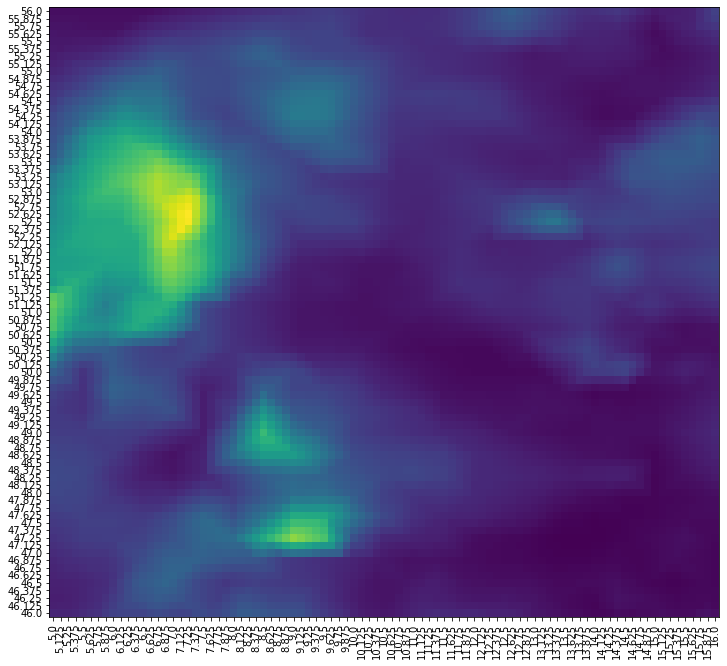

In [8]:
# plotting a single timestep - just as a sanity check; compared it with display in qgis; looks good. 
# Orientation of map is right, plume origins conform with cities.
plotVals(rootgroupMarch['tcno2'][1])

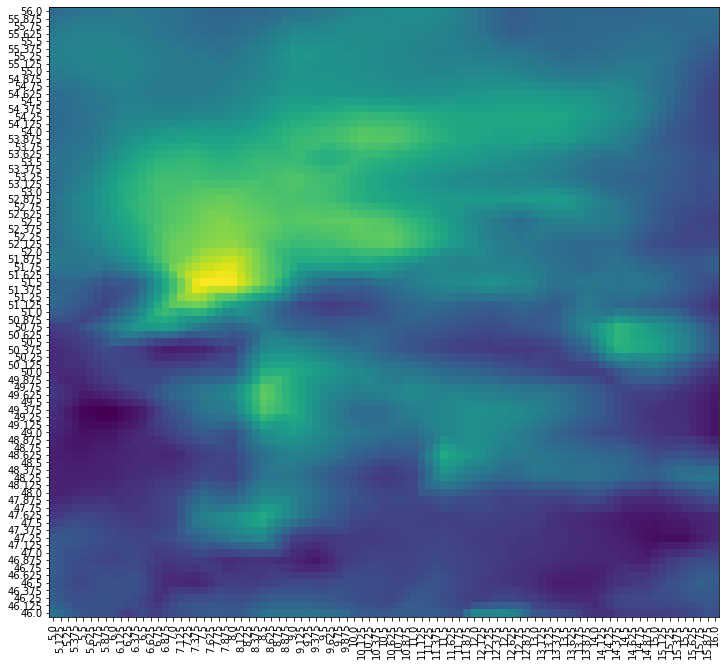

In [9]:
beforeSum = np.sum(beforeVals, axis=0)
afterSum = np.sum(afterVals, axis=0)
plotVals(beforeSum - afterSum)

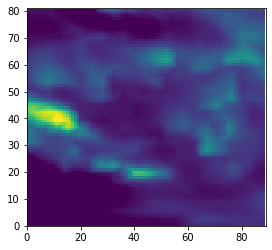

In [10]:
def video(data):
    T, X, Y = data.shape

    fig = plt.figure()
    ax = plt.axes(xlim=(0, Y), ylim=(0, X))
    img = plt.imshow(data[0], animated=True)

    def update(i):
        img.set_data(data[i])
        return [img]
    
    ani = FuncAnimation(fig, update, range(T), blit=True)
    return ani

a = video(rootgroupMarch['tcno2'])
a.save('./output/test_anim.mp4')

In [18]:
lks['beforeCuml'] = np.zeros(len(lks.index))
lks['afterCuml'] = np.zeros(len(lks.index))
lks['observationCount'] = np.zeros(len(lks.index))
R, C = beforeSum.shape

for r in range(R):
    for c in range(C):
        lat = rootgroupMarch['latitude'][r]
        lon = rootgroupMarch['longitude'][c]
        pt = shg.Point(lon, lat)
        for i in lks.index:
            lk = lks.loc[i]
            if lk.geometry.contains(pt):
                lks.loc[i, 'beforeCuml'] += beforeSum[r, c]
                lks.loc[i, 'afterCuml'] += afterSum[r, c]
                lks.loc[i, 'observationCount'] += 1
                print(f"lk {lk['name']} contains point {lon} - {lat}. Before: {lks.loc[i, 'beforeCuml']} After: {lks.loc[i, 'afterCuml']}  ObsCount: {lks.loc[i, 'observationCount']}")
                break


lks['before'] = lks['beforeCuml'] / lks['observationCount']
lks['after'] = lks['afterCuml'] / lks['observationCount']

s contains point 8.25 - 48.0. Before: 0.00037473796843996715 After: 0.000304967050481515  ObsCount: 4.0
lk Schwarzwald-Baar-Kreis contains point 8.375 - 48.0. Before: 0.00046976877757862103 After: 0.00038024859663760496  ObsCount: 5.0
lk Schwarzwald-Baar-Kreis contains point 8.5 - 48.0. Before: 0.000565871754512278 After: 0.00045382676266418116  ObsCount: 6.0
lk Schwarzwald-Baar-Kreis contains point 8.625 - 48.0. Before: 0.000662439789881911 After: 0.0005282966428367278  ObsCount: 7.0
lk Tuttlingen contains point 8.75 - 48.0. Before: 0.00019266332164822036 After: 0.00015141787819896168  ObsCount: 2.0
lk Tuttlingen contains point 8.875 - 48.0. Before: 0.00029015740236653325 After: 0.00022767641359427095  ObsCount: 3.0
lk Tuttlingen contains point 9.0 - 48.0. Before: 0.0003884531207779877 After: 0.0003047651730965451  ObsCount: 4.0
lk Sigmaringen contains point 9.125 - 48.0. Before: 0.0005790205127239931 After: 0.0004717818454412702  ObsCount: 6.0
lk Sigmaringen contains point 9.25 - 48.

In [24]:
lks['beforeNormal'] = lks['before'] / lks.area
lks['afterNormal'] = lks['after'] / lks.area

In [26]:
fractionNo2Traffic = 0.5
lks['NO2_traffic_before'] = lks['before'] * fractionNo2Traffic
lks['NO2_non_traffic'] = lks['before'] * (1 - fractionNo2Traffic)
lks['NO2_traffic_after'] = lks['after'] - lks['NO2_non_traffic']
lks['NO2_diff'] = lks['NO2_traffic_after'] - lks['NO2_traffic_before']
lks['NO2_diff_frac'] = lks['NO2_traffic_after'] / lks['NO2_traffic_before']
lks.head()

,art,name,partof,population,AGS,geometry,beforeCuml,afterCuml,observationCount,before,after,beforeNormal,afterNormal,NO2_traffic_before,NO2_non_traffic,NO2_traffic_after,NO2_diff,NO2_diff_frac
16,landkreis,Halle,Sachsen-Anhalt,239257,15002,"POLYGON ((12.00471 51.53966, 12.04427 51.49398...",0.000249,0.000200,2.0,0.000125,0.000100,0.007363,0.005917,0.000062,0.000062,0.000038,-0.000024,0.607299
17,landkreis,Fürth (Stadt),Bayern,127748,9563,"POLYGON ((10.98974 49.43607, 10.96199 49.45750...",0.000115,0.000093,1.0,0.000115,0.000093,0.014286,0.011498,0.000058,0.000058,0.000035,-0.000022,0.609683
18,landkreis,Neumünster,Schleswig-Holstein,79487,1004,"POLYGON ((10.03454 54.12915, 10.01577 54.07925...",0.000111,0.000072,1.0,0.000111,0.000072,0.010832,0.007066,0.000056,0.000056,0.000017,-0.000039,0.304640
19,landkreis,Eisenach,Thüringen,42370,16056,"POLYGON ((10.18383 50.99842, 10.20182 51.01285...",0.000224,0.000208,2.0,0.000112,0.000104,0.008199,0.007623,0.000056,0.000056,0.000048,-0.000008,0.859468
20,landkreis,Saale-Orla-Kreis,Thüringen,80868,16075,"POLYGON ((11.86614 50.78823, 11.90047 50.78606...",0.001009,0.000939,10.0,0.000101,0.000094,0.000692,0.000644,0.000050,0.000050,0.000043,-0.000007,0.861177


In [31]:
lks.to_file("./data/landkreise_no2_14d.json", driver="GeoJSON", encoding="utf-8")

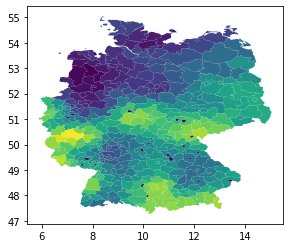

In [29]:
lks.plot(column='NO2_diff_frac')

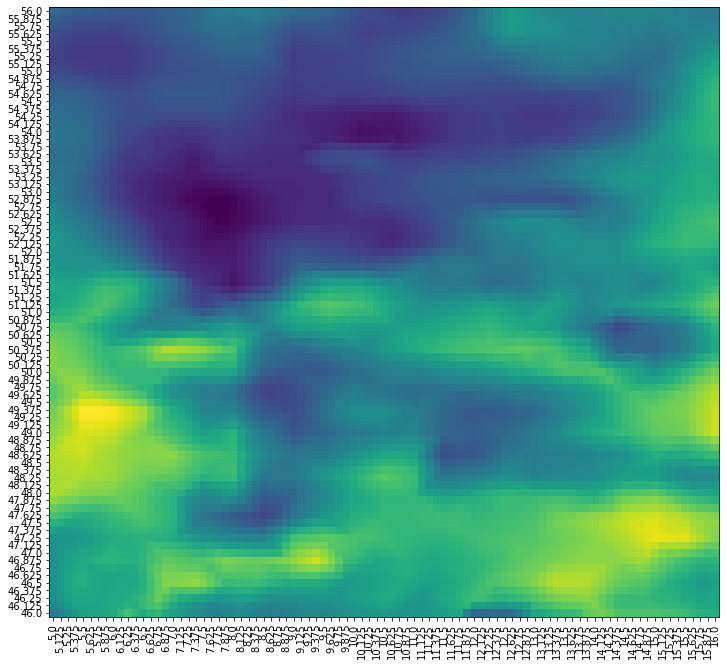

In [30]:
plotVals(afterSum / beforeSum)